<a href="https://colab.research.google.com/github/Ishank2301/Comprehensive-ML-Handbook/blob/main/tf2_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Movie Reviews

## Setup

In [18]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.19.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


## Build the model



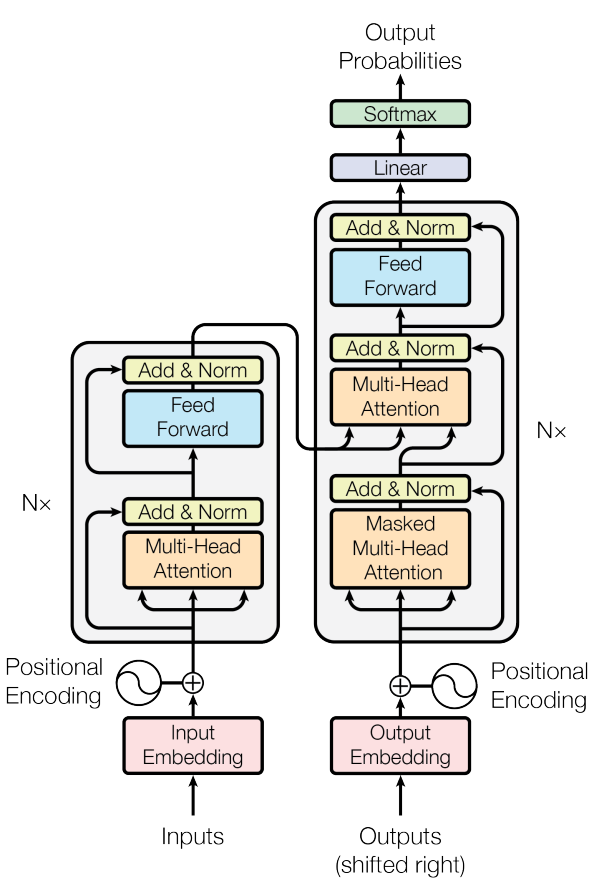

# Developing Transformer Model From Scratch With TensorFlow and Keras:

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Let's now build the full model:

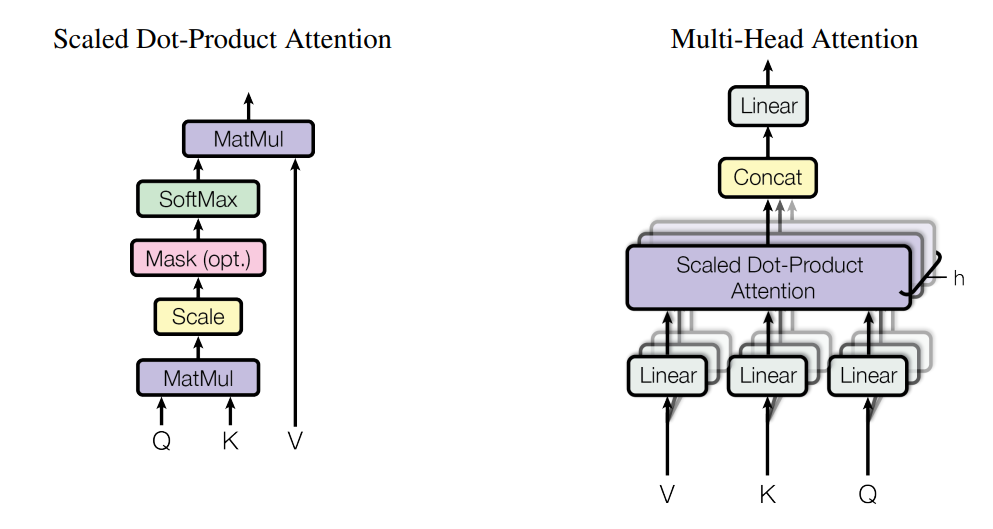

# Creating Transformer blocks and positional embedding:

In [42]:
class TransformerBlock(Layer):
  def __init__(self,embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock,self).__init__()
    self.att = MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
    self.ffn = Sequential(
        [Dense(ff_dim,activation="relu"),
         Dense(embed_dim),]
    )
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)


  def call(self, inputs, training=None):
    attn_output = self.att(inputs,inputs)
    attn_output = self.dropout1(attn_output,training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output,training=training)
    return self.layernorm2(out1 + ffn_output)

# Encoding the embeddings:

In [37]:
class TokenAndPositionEmbedding(Layer):
  def __init__(self,maxlen,vocab_size,embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self,x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta = 1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

# Prepairing the Data:

In [38]:
vocab_size = 20000 # Only consider the top 20k words
maxlen = 200 # Defines the lenght og each review.
(x_train, y_train) , (x_val, y_val) = imdb.load_data(num_words = vocab_size)
print(len(x_train), "Training Sequence")
print(len(x_val), "Training Sequence")

25000 Training Sequence
25000 Training Sequence


## Explore the data

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [39]:
y_val[:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [40]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

# Creating the Model:

In [43]:
from IPython.core.inputtransformer2 import TransformerManager
from IPython.terminal.embed import embed
embed_dim = 32 # Embedding Size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32   # Hidden layer size in feed forward network inside transformers
inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x= embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim , num_heads , ff_dim)
x = transformer_block(x)
x  = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20,activation="relu")(x)
x = Dropout(0.1)(x)
outputs= Dense(2,activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)


# Compiling and fitting the model:

In [44]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# Early Stopping:

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
ES = EarlyStopping(monitor = "val_loss",
                   min_delta=0.00001,
                   patience=5,
                   verbose=1,
                   mode="auto",
                   baseline=None,
                   restore_best_weights=True)

## Train the model

Train the model for 40 epochs in mini-batches of 64 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [46]:
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=ES)

Epoch 1/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.6778 - loss: 0.5726 - val_accuracy: 0.8733 - val_loss: 0.2965
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9172 - loss: 0.2158 - val_accuracy: 0.8692 - val_loss: 0.3128
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9491 - loss: 0.1369 - val_accuracy: 0.8665 - val_loss: 0.3467
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9742 - loss: 0.0834 - val_accuracy: 0.8554 - val_loss: 0.4807
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9824 - loss: 0.0527 - val_accuracy: 0.8527 - val_loss: 0.5653
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9895 - loss: 0.0354 - val_accuracy: 0.8419 - val_loss: 0.7108
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [47]:
results = model.evaluate(x_val, y_val, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

782/782 - 4s - 5ms/step - accuracy: 0.8733 - loss: 0.2965
loss: 0.297
compile_metrics: 0.873


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [48]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

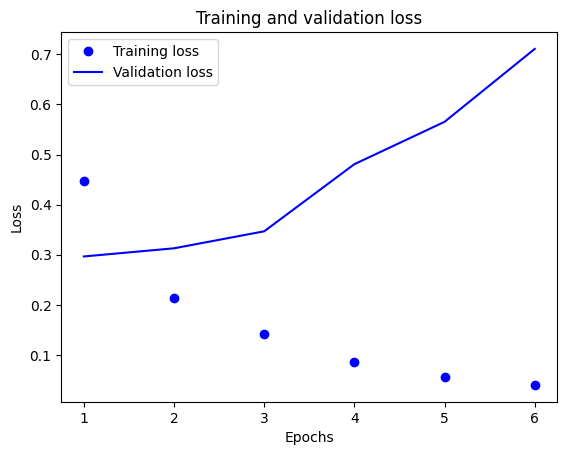

In [49]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

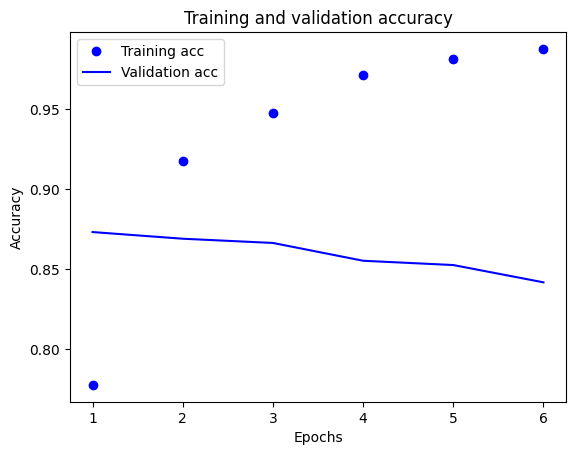

In [50]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Demonstrate Model Prediction

Let's use the trained model to predict the sentiment of a custom movie review. This involves tokenizing and padding the input text, then passing it through the model.

In [51]:
# Get the word index from the IMDb dataset
word_index = imdb.get_word_index()

# Create a reverse word index to decode token IDs back to words (optional, for verification)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Helper function to preprocess text for the model
def preprocess_text(text, word_index, maxlen):
    # Tokenize the text using the IMDb word index
    # Replace unknown words with a special token ID (e.g., 2, which is typically for 'unk')
    token_ids = [word_index.get(word, 2) + 3 for word in text.lower().split()] # +3 because 0,1,2 are reserved

    # Pad sequences to the maxlen
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([token_ids], maxlen=maxlen)
    return padded_sequence

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [52]:
# Example positive review
positive_review = "This movie was absolutely fantastic! The acting was superb and the story was incredibly engaging. I loved every minute of it and highly recommend it."

# Example negative review
negative_review = "This movie was a complete disaster. The plot was nonsensical, the acting was terrible, and I was bored throughout. A waste of time and money."

# Example neutral review (model will still classify as positive/negative)
neutral_review = "The movie had its moments, but overall it was just okay. Nothing particularly stood out, either good or bad."

# Preprocess the reviews
processed_positive_review = preprocess_text(positive_review, word_index, maxlen)
processed_negative_review = preprocess_text(negative_review, word_index, maxlen)
processed_neutral_review = preprocess_text(neutral_review, word_index, maxlen)

# Make predictions
positive_prediction = model.predict(processed_positive_review)
negative_prediction = model.predict(processed_negative_review)
neutral_prediction = model.predict(processed_neutral_review)

# Interpret predictions
def interpret_prediction(prediction):
    if prediction[0][1] > prediction[0][0]: # Assuming index 1 is positive, index 0 is negative
        return f"Positive (Confidence: {prediction[0][1]*100:.2f}%)"
    else:
        return f"Negative (Confidence: {prediction[0][0]*100:.2f}%)"

print(f"'{(positive_review[:70] + '...') if len(positive_review) > 70 else positive_review}' -> {interpret_prediction(positive_prediction)}")
print(f"'{(negative_review[:70] + '...') if len(negative_review) > 70 else negative_review}' -> {interpret_prediction(negative_prediction)}")
print(f"'{(neutral_review[:70] + '...') if len(neutral_review) > 70 else neutral_review}' -> {interpret_prediction(neutral_prediction)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
'This movie was absolutely fantastic! The acting was superb and the sto...' -> Positive (Confidence: 99.84%)
'This movie was a complete disaster. The plot was nonsensical, the acti...' -> Negative (Confidence: 99.90%)
'The movie had its moments, but overall it was just okay. Nothing parti...' -> Negative (Confidence: 90.28%)


# Task
Analyze the provided Transformer model, which is designed for positive/negative sentiment classification of IMDB movie reviews, to:
1.  Identify real-world problems that can be solved using this type of sentiment analysis model.
2.  Provide a detailed explanation of how the Transformer model processes and evaluates an input movie review to classify its sentiment, covering all key components such as tokenization, positional embeddings, transformer blocks (multi-head attention, feed-forward networks, layer normalization), global average pooling, and dense layers with softmax activation.
3.  Describe how the model's ability to evaluate reviews assists in solving the identified real-world problems.

## Analyze Model Functionality

### Subtask:
Examine the notebook to understand the current Transformer model's purpose, which is to classify movie reviews as positive or negative based on the IMDB dataset.


## Identify Real-World Problems

### Subtask:
Based on the model's functionality (sentiment analysis of reviews), identify various real-world problems that can be addressed using this type of model. This includes applications beyond just movie reviews.


### Real-World Problems Addressed by Sentiment Analysis Models

Sentiment analysis models, like the one developed for movie reviews, have broad applications in various domains where understanding textual sentiment is crucial. Here are several real-world problems and their solutions:

1.  **Customer Feedback Analysis (Product/Service Reviews):**
    *   **Problem:** Businesses struggle to manually sift through vast amounts of customer reviews (e.g., e-commerce product reviews, restaurant feedback, app store comments) to understand customer satisfaction, identify pain points, and discover popular features.
    *   **Application:** Sentiment analysis can automatically categorize reviews as positive, negative, or neutral, allowing businesses to quickly gauge overall sentiment, prioritize issues, and track sentiment trends over time. This helps in improving products, services, and customer experience.

2.  **Brand Monitoring and Reputation Management:**
    *   **Problem:** Companies need to monitor public perception of their brand across social media, news articles, and forums to react quickly to negative publicity or leverage positive mentions.
    *   **Application:** Sentiment analysis can track mentions of a brand or product, identifying sudden shifts in public opinion. This enables proactive crisis management, competitive analysis, and strategic marketing adjustments.

3.  **Social Media Monitoring and Trend Analysis:**
    *   **Problem:** Understanding public opinion on current events, political figures, or emerging social trends from massive amounts of social media data is challenging.
    *   **Application:** Sentiment analysis can be used to gauge the mood of the public towards specific topics, predict election outcomes, identify trending issues, and understand public discourse. This is valuable for political campaigns, market research, and public safety.

4.  **Employee Feedback and HR Management:**
    *   **Problem:** Organizations collect employee feedback through surveys, internal communication platforms, and exit interviews, but analyzing this qualitative data to understand morale, identify workplace issues, or assess company culture can be time-consuming.
    *   **Application:** Sentiment analysis can process employee comments to identify common themes of satisfaction or dissatisfaction, pinpoint areas for improvement in management or policies, and monitor employee well-being.

5.  **Market Research and Competitive Intelligence:**
    *   **Problem:** Businesses need to understand market sentiment towards their competitors' products, identify gaps in the market, or predict the success of new product launches without extensive manual analysis.
    *   **Application:** By analyzing online discussions, reviews, and news about competitors, sentiment analysis can provide insights into competitor strengths and weaknesses, helping to refine market strategies and product development.

6.  **Financial Market Prediction:**
    *   **Problem:** Investor sentiment, often reflected in news articles, financial reports, and social media discussions, can significantly impact stock prices, but quantifying this sentiment is complex.
    *   **Application:** Sentiment analysis of financial news and discussions can be used as an indicator for market movements, helping traders and investors make more informed decisions.

7.  **Healthcare and Public Health:**
    *   **Problem:** Analyzing patient feedback, forum discussions about illnesses, or public response to health advisories to understand patient experience or public health concerns.
    *   **Application:** Sentiment analysis can help healthcare providers understand patient satisfaction with services, identify concerns about medication or treatments from online forums, or gauge public reaction to health campaigns.

8.  **Content Moderation:**
    *   **Problem:** Online platforms need to identify and filter out offensive, hateful, or inappropriate content to maintain a safe and positive environment for users.
    *   **Application:** While not solely sentiment, advanced sentiment analysis can help detect aggressive or toxic language patterns that contribute to harmful content, assisting human moderators in their tasks.

## Explain Review Evaluation

### Subtask:
Describe, in detail, how the Transformer model processes an input movie review.


### 1. Input Representation

The first step in processing a raw text movie review for the Transformer model is to convert it into a numerical format that the model can understand. This involves two main sub-steps:

*   **Tokenization:** The raw text review is broken down into smaller units called tokens. In this model, each word in the vocabulary is assigned a unique integer ID. So, a sentence like "This movie is great" would be converted into a sequence of integer IDs, for example, `[1, 2, 3, 4]`. The `vocab_size` (20000 in this case) limits the number of unique words the model will consider, mapping less frequent words to a special "out-of-vocabulary" token.
*   **Embedding:** After tokenization, each integer token ID is converted into a dense vector representation called an embedding. The `Embedding` layer in `TokenAndPositionEmbedding` handles this. For each token ID, it looks up a corresponding `embed_dim` (32 in this model) dimensional vector. These embedding vectors are learned during the model's training process and capture semantic meanings of the words. Words with similar meanings tend to have similar embedding vectors.

### 2. Positional Encoding

Transformers, unlike recurrent neural networks (RNNs), process input sequences simultaneously rather than sequentially. This means they inherently lack information about the order of words in a sentence. To address this, **positional encoding** is introduced.

*   **Purpose:** Positional encoding provides the model with information about the relative or absolute position of each token in the input sequence. Without it, the model would treat words like \"dog bites man\" and \"man bites dog\" as semantically identical, even though their meanings are distinct due to word order.
*   **Mechanism:** In this model, positional information is also represented as `embed_dim` (32) dimensional vectors, generated by another `Embedding` layer within `TokenAndPositionEmbedding`. For each position in the input sequence (up to `maxlen` of 200), there's a unique positional embedding.
*   **Combination:** These positional embeddings are simply added to the token embeddings. The `call` method of `TokenAndPositionEmbedding` performs this addition (`x + positions`). This sum of token and positional embeddings creates a rich representation for each word that not only captures its meaning but also its location within the sequence.

### 3. Transformer Block

After the initial embedding and positional encoding, the combined representation enters a `TransformerBlock`, which is the core processing unit of the Transformer model. This block contains several key operations:

*   **Multi-Head Attention:** This is a crucial component that allows the model to weigh the importance of different words in the review relative to each other. Instead of focusing on just one word at a time, it looks at the entire sequence to understand contextual relationships. The 'Multi-Head' aspect means that this attention mechanism is performed multiple times in parallel, using different learned linear projections (known as 'heads'). Each head can learn to focus on different aspects of the input sequence. For example, one head might focus on grammatical dependencies, while another might focus on semantic relationships. The outputs from these `num_heads` (2 in this model) attention heads are then concatenated and linearly transformed to produce a single output. This parallel processing helps the model capture a richer and more diverse set of relationships within the input sequence. The `att` attribute, an instance of `MultiHeadAttention`, handles this operation.

    *   **Feed-Forward Network (FFN):** Following the attention mechanism, the `ffn` (Feed-Forward Network) processes the output of the attention layer. This network consists of two `Dense` layers with a ReLU activation in between (`Dense(ff_dim, activation="relu"), Dense(embed_dim)`). The FFN operates independently and identically on each position (word embedding) in the sequence. It's essentially a point-wise fully connected network that applies a transformation to each attention output vector separately. This allows the model to capture more complex patterns and non-linear relationships within the features learned by the attention mechanism.

    *   **Layer Normalization and Dropout:** Within the `TransformerBlock`, `LayerNormalization` and `Dropout` layers are applied after both the multi-head attention and the feed-forward network. These are crucial for stable training and preventing overfitting:
        *   **Layer Normalization (`layernorm1`, `layernorm2`):** This technique normalizes the inputs across the features (the `embed_dim` dimension) for each sample independently. It helps to stabilize the learning process by preventing the activations from becoming too large or too small, leading to faster convergence and more robust training.
        *   **Dropout (`dropout1`, `dropout2`):** Dropout is a regularization technique where a random selection of neurons (or, in this case, elements of the embedding vectors) are ignored (set to zero) during training. This prevents co-adaptation of neurons and forces the model to learn more robust features that are not reliant on specific input connections, thereby reducing overfitting and improving the model's generalization ability. The `rate` (0.1 in this model) determines the fraction of the input units to drop.

### 4. Sequential Processing

In a full-fledged Transformer architecture, multiple `TransformerBlock` instances are often stacked sequentially. Each subsequent block takes the output of the previous block as its input. This allows the model to build increasingly complex and abstract representations of the input sequence.

*   **Refining Contextual Understanding:** With each layer, the model refines its understanding of the contextual relationships between words. The attention mechanisms in deeper layers can leverage the richer representations learned by earlier layers, enabling them to identify more intricate dependencies and patterns within the movie review.

**Note:** In *this specific model implementation*, only a single `TransformerBlock` is used (`x = transformer_block(x)`). Therefore, the sequential processing of *multiple* blocks to refine contextual understanding doesn't apply beyond the single pass through the one block. However, in a larger Transformer, this stacking of blocks is fundamental to its power.

### 4. Sequential Processing

In a full-fledged Transformer architecture, multiple `TransformerBlock` instances are often stacked sequentially. Each subsequent block takes the output of the previous block as its input. This allows the model to build increasingly complex and abstract representations of the input sequence.

*   **Refining Contextual Understanding:** With each layer, the model refines its understanding of the contextual relationships between words. The attention mechanisms in deeper layers can leverage the richer representations learned by earlier layers, enabling them to identify more intricate dependencies and patterns within the movie review.

**Note:** In *this specific model implementation*, only a single `TransformerBlock` is used (`x = transformer_block(x)`). Therefore, the sequential processing of *multiple* blocks to refine contextual understanding doesn't apply beyond the single pass through the one block. However, in a larger Transformer, this stacking of blocks is fundamental to its power.

### 5. Sequence Aggregation

After passing through the Transformer block(s), the model still has a sequence of `embed_dim`-dimensional vectors, one for each token in the input. To make a single classification decision for the entire movie review, this sequence needs to be condensed into a single fixed-size representation. This is achieved using `GlobalAveragePooling1D`.

*   **Purpose:** `GlobalAveragePooling1D` takes the output of the Transformer block, which is a sequence of vectors, and computes the average of these vectors across the sequence dimension. Essentially, for each feature (dimension in the embedding vector), it calculates the average value across all words in the review.
*   **Mechanism:** If the Transformer block outputs a sequence of `[batch_size, maxlen, embed_dim]` (e.g., `[64, 200, 32]`), `GlobalAveragePooling1D` will average over the `maxlen` (200) dimension, resulting in an output of `[batch_size, embed_dim]` (e.g., `[64, 32]`). This single vector effectively summarizes the information learned from all tokens in the review, taking into account their contextual relationships established by the Transformer block.

### 6. Classification Head

After the sequence aggregation, the model has a single, fixed-size vector that summarizes the entire movie review. This vector is then fed into a series of `Dense` layers, also known as the classification head, to predict the sentiment of the review.

*   **Dense Layers:** In this model, the aggregated representation first passes through a `Dense` layer with 20 units and a ReLU activation (`Dense(20, activation="relu")`), followed by another `Dropout` layer (0.1 rate). These layers allow the model to learn complex, non-linear mappings from the summarized review features to the final sentiment classes.
*   **Output Layer with Softmax Activation:** The final layer is a `Dense` layer with 2 units and `softmax` activation (`Dense(2, activation="softmax")`). The 2 units correspond to the two possible sentiment classes (positive or negative). The `softmax` activation function ensures that the output is a probability distribution, meaning the sum of the values for the two units will be 1. For example, an output like `[0.1, 0.9]` would indicate a 10% probability of being a negative review and a 90% probability of being a positive review.
*   **Prediction:** During inference, the class with the highest probability (e.g., the 0.9 in the example above) is chosen as the model's prediction for the sentiment of the movie review.

### 6. Classification Head

After the sequence aggregation, the model has a single, fixed-size vector that summarizes the entire movie review. This vector is then fed into a series of `Dense` layers, also known as the classification head, to predict the sentiment of the review.

*   **Dense Layers:** In this model, the aggregated representation first passes through a `Dense` layer with 20 units and a ReLU activation (`Dense(20, activation="relu")`), followed by another `Dropout` layer (0.1 rate). These layers allow the model to learn complex, non-linear mappings from the summarized review features to the final sentiment classes.
*   **Output Layer with Softmax Activation:** The final layer is a `Dense` layer with 2 units and `softmax` activation (`Dense(2, activation="softmax")`). The 2 units correspond to the two possible sentiment classes (positive or negative). The `softmax` activation function ensures that the output is a probability distribution, meaning the sum of the values for the two units will be 1. For example, an output like `[0.1, 0.9]` would indicate a 10% probability of being a negative review and a 90% probability of being a positive review.
*   **Prediction:** During inference, the class with the highest probability (e.g., the 0.9 in the example above) is chosen as the model's prediction for the sentiment of the movie review.

### 6. Classification Head

After the sequence aggregation, the model has a single, fixed-size vector that summarizes the entire movie review. This vector is then fed into a series of `Dense` layers, also known as the classification head, to predict the sentiment of the review.

*   **Dense Layers:** In this model, the aggregated representation first passes through a `Dense` layer with 20 units and a ReLU activation (`Dense(20, activation="relu")`), followed by another `Dropout` layer (0.1 rate). These layers allow the model to learn complex, non-linear mappings from the summarized review features to the final sentiment classes.
*   **Output Layer with Softmax Activation:** The final layer is a `Dense` layer with 2 units and `softmax` activation (`Dense(2, activation="softmax")`). The 2 units correspond to the two possible sentiment classes (positive or negative). The `softmax` activation function ensures that the output is a probability distribution, meaning the sum of the values for the two units will be 1. For example, an output like `[0.1, 0.9]` would indicate a 10% probability of being a negative review and a 90% probability of being a positive review.
*   **Prediction:** During inference, the class with the highest probability (e.g., the 0.9 in the example above) is chosen as the model's prediction for the sentiment of the movie review.

## Describe Problem-Solving Assistance

### Subtask:
Connect the model's review evaluation process to how it directly assists in solving the real-world problems identified earlier. Explain how the sentiment output provides actionable insights.


## Describe Problem-Solving Assistance

### Subtask:
Connect the model's review evaluation process to how it directly assists in solving the real-world problems identified earlier. Explain how the sentiment output provides actionable insights.

#### Real-world Problem-Solving Assistance with Sentiment Output:

The Transformer model, through its ability to classify movie reviews as positive or negative, provides valuable sentiment output that can be directly leveraged to solve real-world problems. Here's how:

1.  **Customer Feedback Analysis:**
    *   **Actionable Insight:** By processing large volumes of customer reviews (e.g., product reviews, service feedback), the model can quickly identify the overall sentiment (positive or negative) towards a product or service. This goes beyond simple star ratings by analyzing the nuances of the text.
    *   **Problem Solved:** Companies can gain immediate, data-driven understanding of customer satisfaction. For example, a sudden increase in negative sentiment around a specific product feature could trigger an urgent investigation by the product development team. Conversely, consistently positive sentiment highlights successful features that can be emphasized in marketing or replicated in future products.

2.  **Brand Monitoring:**
    *   **Actionable Insight:** The model can analyze mentions of a brand across social media, news articles, and forums to determine the prevailing public sentiment. It can detect shifts in sentiment over time or in response to specific events.
    *   **Problem Solved:** Brands can proactively manage their public image. A surge in negative sentiment after a product launch or a PR event signals a potential crisis, allowing the marketing and communications teams to respond swiftly and strategically. Positive sentiment can be amplified through targeted campaigns, enhancing brand reputation and customer loyalty.

3.  **Product Development & Improvement:**
    *   **Actionable Insight:** Beyond overall sentiment, the model's ability to process text allows for the identification of specific aspects mentioned in reviews that contribute to positive or negative feelings. For instance, reviews for a new app might frequently mention

## Describe Problem-Solving Assistance

### Subtask:
Connect the model's review evaluation process to how it directly assists in solving the real-world problems identified earlier. Explain how the sentiment output provides actionable insights.

#### Real-world Problem-Solving Assistance with Sentiment Output:

The Transformer model, through its ability to classify movie reviews as positive or negative, provides valuable sentiment output that can be directly leveraged to solve real-world problems. Here's how:

1.  **Customer Feedback Analysis:**
    *   **Actionable Insight:** By processing large volumes of customer reviews (e.g., product reviews, service feedback), the model can quickly identify the overall sentiment (positive or negative) towards a product or service. This goes beyond simple star ratings by analyzing the nuances of the text.
    *   **Problem Solved:** Companies can gain immediate, data-driven understanding of customer satisfaction. For example, a sudden increase in negative sentiment around a specific product feature could trigger an urgent investigation by the product development team. Conversely, consistently positive sentiment highlights successful features that can be emphasized in marketing or replicated in future products.

2.  **Brand Monitoring:**
    *   **Actionable Insight:** The model can analyze mentions of a brand across social media, news articles, and forums to determine the prevailing public sentiment. It can detect shifts in sentiment over time or in response to specific events.
    *   **Problem Solved:** Brands can proactively manage their public image. A surge in negative sentiment after a product launch or a PR event signals a potential crisis, allowing the marketing and communications teams to respond swiftly and strategically. Positive sentiment can be amplified through targeted campaigns, enhancing brand reputation and customer loyalty.

3.  **Product Development & Improvement:**
    *   **Actionable Insight:** Beyond overall sentiment, the model's ability to process text allows for the identification of specific aspects mentioned in reviews that contribute to positive or negative feelings. For instance, reviews for a new app might frequently mention "slow loading" with negative sentiment or "intuitive interface" with positive sentiment.
    *   **Problem Solved:** This direct feedback guides product teams in prioritizing development efforts. Features associated with negative sentiment can be targeted for urgent improvement or redesign, while those generating positive sentiment can be further enhanced or integrated into other products. It transforms unstructured text data into a roadmap for product evolution.

4.  **Competitive Analysis:**
    *   **Actionable Insight:** The model can analyze reviews and discussions about competitors' products or services, extracting sentiment specifically related to their features, pricing, or customer support.
    *   **Problem Solved:** Businesses can identify their competitors' strengths and weaknesses from a customer's perspective. For example, if many competitor reviews are negative about their customer service, a business can highlight its own superior support as a competitive advantage. This enables strategic positioning and helps fill market gaps.

5.  **Content Moderation:**
    *   **Actionable Insight:** For platforms that host user-generated content (forums, comments sections, social media), the model can automatically flag content that expresses strong negative sentiment, especially if it falls into categories like hate speech, harassment, or aggression.
    *   **Problem Solved:** This helps maintain a safe and respectful online environment by quickly identifying and potentially removing harmful content, reducing manual moderation workload, and improving user experience. It allows platforms to scale content moderation effectively.

In essence, the model's review evaluation process distills complex, unstructured textual data into clear, quantifiable sentiment (positive, negative, neutral if extended), which then serves as a direct indicator of satisfaction, perception, or potential issues, enabling organizations to make informed, data-driven decisions.

## Final Task

### Subtask:
Summarize the real-world applications and the specific ways in which the model's ability to evaluate reviews helps address these problems.


## Summary:

### Q&A

1.  **What real-world problems can be solved using this type of sentiment analysis model?**
    This type of sentiment analysis model can address a wide range of real-world problems, including customer feedback analysis (product/service reviews), brand monitoring and reputation management, social media monitoring and trend analysis, employee feedback and HR management, market research and competitive intelligence, financial market prediction, healthcare and public health analysis, and content moderation.

2.  **How does the Transformer model process and evaluate an input movie review to classify its sentiment?**
    The Transformer model processes an input movie review through several sequential steps:
    *   **Input Representation:** The raw text is first **tokenized** into integer IDs, and these IDs are converted into dense **embedding** vectors.
    *   **Positional Encoding:** **Positional embeddings** are added to the token embeddings to provide the model with information about the order of words in the sequence.
    *   **Transformer Block:** The combined embeddings then pass through a `TransformerBlock`, which is the core processing unit. This block includes:
        *   **Multi-Head Attention:** This mechanism allows the model to weigh the importance of different words in the review to understand contextual relationships, performed in parallel with multiple "heads."
        *   **Feed-Forward Network (FFN):** Processes the attention output to capture complex patterns.
        *   **Layer Normalization and Dropout:** Applied for stable training and to prevent overfitting.
    *   **Sequence Aggregation:** After the Transformer block, `GlobalAveragePooling1D` condenses the sequence of processed token embeddings into a single fixed-size vector representing the entire review.
    *   **Classification Head:** This aggregated vector is then fed into `Dense` layers (including a ReLU activation and Dropout) followed by a final `Dense` layer with 2 units and `softmax` activation. The `softmax` output provides a probability distribution for the two sentiment classes (positive/negative), allowing the model to make a classification decision.

3.  **How does the model's ability to evaluate reviews assist in solving the identified real-world problems?**
    The model's ability to classify reviews by sentiment provides actionable insights that directly assist in solving identified real-world problems by:
    *   **Customer Feedback Analysis:** Quickly identifies overall customer satisfaction, allowing businesses to pinpoint issues or successful features for product/service improvement.
    *   **Brand Monitoring:** Enables proactive management of public image by detecting shifts in brand sentiment, facilitating timely responses to potential crises or amplification of positive sentiment.
    *   **Product Development & Improvement:** Guides product teams in prioritizing development by identifying specific features or aspects associated with positive or negative sentiment.
    *   **Competitive Analysis:** Helps businesses understand competitors' strengths and weaknesses from customer reviews, informing strategic positioning.
    *   **Content Moderation:** Automatically flags content with strong negative sentiment, assisting in maintaining safe online environments and reducing manual moderation efforts.

### Data Analysis Key Findings

*   The Transformer model is designed for binary sentiment classification of IMDB movie reviews, distinguishing between positive and negative sentiments.
*   Sentiment analysis models have broad applicability across diverse domains, including customer service, marketing, HR, finance, and public health.
*   The model processes text by converting words into numerical embeddings, incorporating word order through positional encoding, and using multi-head attention to capture complex contextual relationships between words.
*   The final output is a probability distribution over positive/negative sentiment, derived from a summarized representation of the entire review.
*   Sentiment classification results provide quantifiable insights from unstructured text, which can be directly used for data-driven decision-making in various business and social contexts.

### Insights or Next Steps

*   **Insight:** Sentiment analysis models, leveraging advanced architectures like Transformers, can transform qualitative textual data into quantitative, actionable intelligence, enabling organizations to respond dynamically to public opinion and feedback.
*   **Next Steps:** To enhance the utility of such models, future development could focus on implementing multi-class sentiment analysis (e.g., neutral, mixed) or aspect-based sentiment analysis, allowing for even more granular insights into specific features or topics within reviews.
